In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# Importing dependencies

In [ ]:
!pip install wandb

     |████████████████████████████████| 1.4MB 2.7MB/s 
     |████████████████████████████████| 163kB 13.4MB/s 
     |████████████████████████████████| 102kB 8.0MB/s 
     |████████████████████████████████| 122kB 15.6MB/s 
     |████████████████████████████████| 102kB 8.0MB/s 
     |████████████████████████████████| 71kB 8.0MB/s 
     |████████████████████████████████| 71kB 7.3MB/s 
  Created wheel for gql: filename=gql-0.2.0-cp36-none-any.whl size=7630 sha256=d3a257df7881c1297bfd971b9c9d4995d43354112db658e1e22013e0704c9348
  Stored in directory: /root/.cache/pip/wheels/ce/0e/7b/58a8a5268655b3ad74feef5aa97946f0addafb3cbb6bd2da23
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp36-none-any.whl size=6489 sha256=93ebad880afbea0ceaf0173b6cf3318138f29678e55e29d615e0292d1464e5df
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
  Created wheel for watchdog: filename=watchdog-0.10.3-cp36-none-any.whl size=73870 sha256=01f2

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import os
import random
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
import wandb
wandb.init(project="mnist-gans", name="dcgan")

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


W&B Run: https://app.wandb.ai/elita04/mnist-gans/runs/25sgcp4o

# Data Loading

## Download and normalize to range [-1, 1]

In [ ]:
dataset_train = torchvision.datasets.FashionMNIST('./train', train=True, download=True, 
                                                  transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.5), std=(0.5))]))

Extracting ./train/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./train/FashionMNIST/raw



Extracting ./train/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./train/FashionMNIST/raw


Extracting ./train/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./train/FashionMNIST/raw


Extracting ./train/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./train/FashionMNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
dataset_test = torchvision.datasets.FashionMNIST('./test', train=False, download=True, 
                                                  transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.5), std=(0.5))]))

Extracting ./test/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./test/FashionMNIST/raw


Extracting ./test/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./test/FashionMNIST/raw


Extracting ./test/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./test/FashionMNIST/raw


Extracting ./test/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./test/FashionMNIST/raw
Processing...
Done!


In [ ]:
# Change labels of dataset to real
dataset_train.targets = torch.ones(len(dataset_train))
dataset_test.targets = torch.ones(len(dataset_test))

In [ ]:
labels_map = {0: 'Fake', 1: 'Real'}

## Concatenating train and test dataset

In [ ]:
dataset = dataset_train + dataset_test
print(f'Length of complete dataset : {len(dataset)}')

Length of complete dataset : 70000


## Initializing constants

In [ ]:
torch.cuda.is_available()

True

In [ ]:
params = {}
params['epochs'] = 20
params['output_after_every_n_epochs'] = 1
params['image_size'] = 28
params['noise_size'] = 100
params['batch_size'] = 64
params['num_channels'] = 1
params['seed'] = 0
wandb.config.update(params)

In [ ]:
def show_grid(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [ ]:
# Note: PyTorch does not guarantee reproducability
# Taken from https://www.kaggle.com/bminixhofer/deterministic-neural-networks-using-pytorch
def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything(params['seed'])

## Convert into DataLoader

In [ ]:
datasetloader = torch.utils.data.DataLoader(dataset_train, batch_size=params['batch_size'], shuffle=True)

In [ ]:
# This is just for visualization and a little debugging
dataiter = iter(datasetloader)

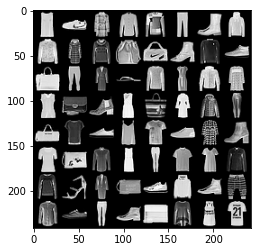

In [ ]:
images, labels = dataiter.next()
show_grid(torchvision.utils.make_grid(images, normalize=True))

# Initialize Weights

In [ ]:
def initialize_weights(model):
    className = model.__class__.__name__
    if className.find('Conv') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
    elif className.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

# Generator Network

## Create Network

Hout = (Hin −1) × stride[0] − 2 × padding[0] + dilation[0] × (kernel_size[0] − 1) + output_padding[0] + 1

Wout = (Win −1) × stride[1] − 2 × padding[1] + dilation[1] × (kernel_size[1] − 1) + output_padding[1] + 1

In [ ]:
class Generator(nn.Module):
    '''
    The Generator Network
    '''

    def __init__(self, noise_size, num_channels):
        super(Generator, self).__init__()

        self.conv_trans_1 = nn.Sequential(
            nn.ConvTranspose2d(noise_size, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True)
        )
        # Shape [2 x 2]

        self.conv_trans_2 = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True)
        )
        # Shape [4 x 4]

        self.conv_trans_3 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 1, 0, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True)
        )
        # Shape [7 x 7]

        self.conv_trans_4 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True)
        )
        # Shape [14 x 14]

        self.output_layer = nn.Sequential(
            nn.ConvTranspose2d(64, num_channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )
        # Shape [28 x 28]

        self.optimizer = optim.Adam(self.parameters(), lr=0.0002, betas=(0.5, 0.999))

    def forward(self, inputs):
        x = self.conv_trans_1(inputs)
        x = self.conv_trans_2(x)
        x = self.conv_trans_3(x)
        x = self.conv_trans_4(x)
        return self.output_layer(x)

In [ ]:
generator = Generator(params['noise_size'], params['num_channels'])
generator.apply(initialize_weights)
generator.cuda()

Generator(
  (conv_trans_1): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv_trans_2): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv_trans_3): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv_trans_4): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (outp

## Test output shape of Generator

torch.Size([64, 1, 28, 28])


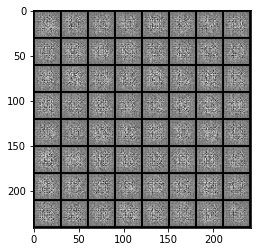

In [ ]:
with torch.no_grad():
    # Note: model still in training mode
    noise = torch.randn(size=(params['batch_size'], params['noise_size'], 1, 1)).cuda()
    output = generator(noise).detach()
    print(output.shape)
show_grid(torchvision.utils.make_grid(output.cpu(), normalize=True))

# Discriminator Network

Hout = ( (Hin + 2 × padding[0] − dilation[0] × (kernel_size[0] − 1) - 1) / stride[0]) + 1

Wout = ( (Win + 2 × padding[1] − dilation[1] × (kernel_size[1] − 1) - 1) / stride[1]) + 1


In [ ]:
class Discriminator(nn.Module):
    '''
    The Discriminator Network
    '''

    def __init__(self, num_channels):
        super(Discriminator, self).__init__()

        self.conv_1 = nn.Sequential(
            nn.Conv2d(num_channels, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True)
        )
        # Shape [14 x 14]

        self.conv_2 = nn.Sequential(
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True)
        )
        # Shape [7 x 7]

        self.conv_3 = nn.Sequential(
            nn.Conv2d(128, 256, 4, 1, 0, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
        )
        # Shape [4 x 4]

        self.conv_4 = nn.Sequential(
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )
        # Shape [2 x 2]

        self.output_layer = nn.Sequential(
            nn.Conv2d(512, 1, 4, 2, 1, bias=False),
            nn.Sigmoid()
        )

        self.optimizer = optim.Adam(self.parameters(), lr=0.0002, betas=(0.5, 0.999))

    def forward(self, inputs):
        x = self.conv_1(inputs)
        x = self.conv_2(x)
        x = self.conv_3(x)
        x = self.conv_4(x)
        return self.output_layer(x)

In [ ]:
discriminator = Discriminator(params['num_channels'])
discriminator.apply(initialize_weights)
discriminator.cuda()

Discriminator(
  (conv_1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv_3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv_4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(nega

# Specifying Loss Function

In [ ]:
adversarial_loss = nn.BCELoss()

# Plotting output after each epoch

In [ ]:
# Fixed input noise
fixed_noise = torch.randn(size=(params['batch_size'], params['noise_size'], 1, 1)).cuda()
def save_output(epoch):
    plt.clf()
    with torch.no_grad():

        generator.eval()
        test_images = generator(fixed_noise)
        generator.train()

        grid = torchvision.utils.make_grid(test_images.cpu(), normalize=True)
        show_grid(grid)
    wandb.log({'output': wandb.Image(grid, caption=f'Output for epoch: {epoch}')}, step=epoch)

# Training DCGAN

Epoch: 1 / 20
Discriminator Total Loss: 0.289, Generator Total Loss: 3.551


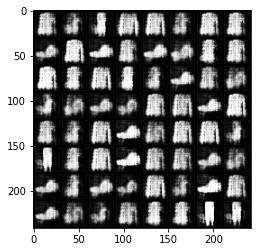

Epoch: 2 / 20
Discriminator Total Loss: 0.279, Generator Total Loss: 3.583


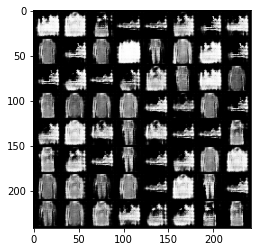

Epoch: 3 / 20
Discriminator Total Loss: 0.410, Generator Total Loss: 3.183


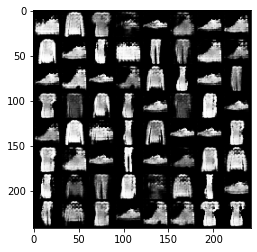

Epoch: 4 / 20
Discriminator Total Loss: 0.461, Generator Total Loss: 2.795


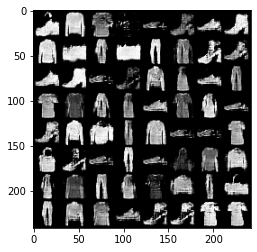

Epoch: 5 / 20
Discriminator Total Loss: 0.484, Generator Total Loss: 2.710


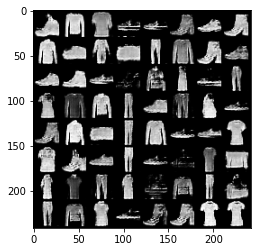

Epoch: 6 / 20
Discriminator Total Loss: 0.478, Generator Total Loss: 2.696


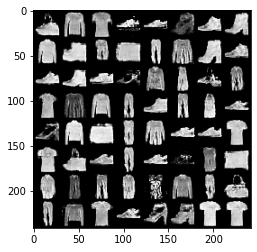

Epoch: 7 / 20
Discriminator Total Loss: 0.470, Generator Total Loss: 2.704


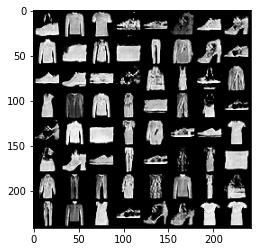

Epoch: 8 / 20
Discriminator Total Loss: 0.500, Generator Total Loss: 2.694


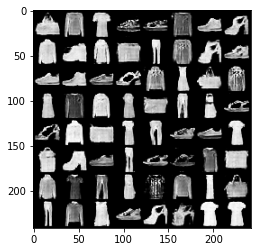

Epoch: 9 / 20
Discriminator Total Loss: 0.442, Generator Total Loss: 2.751


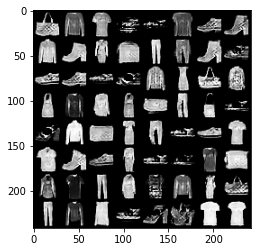

Epoch: 10 / 20
Discriminator Total Loss: 0.459, Generator Total Loss: 2.792


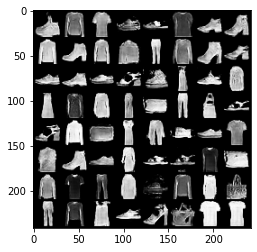

Epoch: 11 / 20
Discriminator Total Loss: 0.425, Generator Total Loss: 2.866


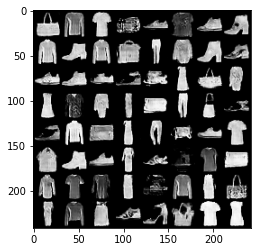

Epoch: 12 / 20
Discriminator Total Loss: 0.404, Generator Total Loss: 2.984


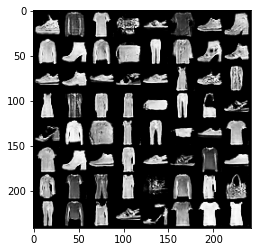

Epoch: 13 / 20
Discriminator Total Loss: 0.376, Generator Total Loss: 3.135


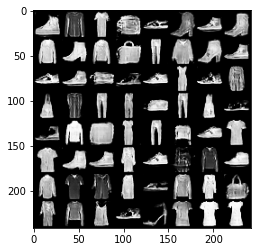

Epoch: 14 / 20
Discriminator Total Loss: 0.378, Generator Total Loss: 3.140


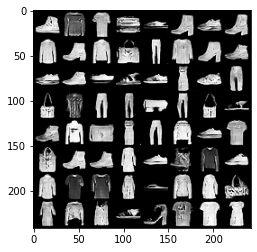

Epoch: 15 / 20
Discriminator Total Loss: 0.389, Generator Total Loss: 3.149


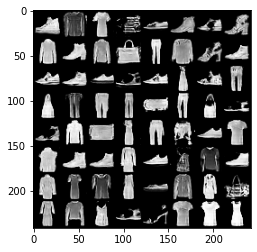

Epoch: 16 / 20
Discriminator Total Loss: 0.363, Generator Total Loss: 3.245


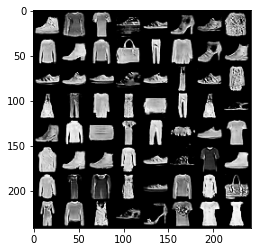

Epoch: 17 / 20
Discriminator Total Loss: 0.357, Generator Total Loss: 3.328


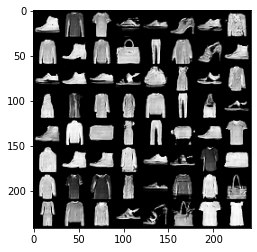

Epoch: 18 / 20
Discriminator Total Loss: 0.340, Generator Total Loss: 3.485


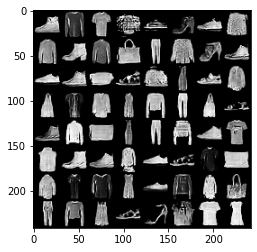

Epoch: 19 / 20
Discriminator Total Loss: 0.336, Generator Total Loss: 3.486


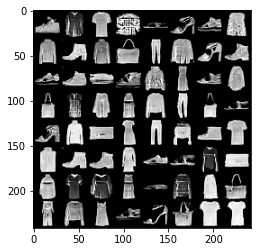

Epoch: 20 / 20
Discriminator Total Loss: 0.323, Generator Total Loss: 3.505


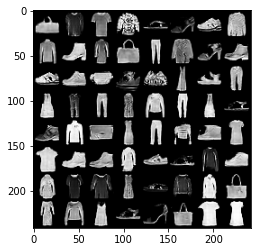

True

In [ ]:
# Set tdqm for epoch progress
pbar = tqdm()
images = []

wandb.watch(generator)
wandb.watch(discriminator)

for epoch in range(params['epochs']):
    print(f'Epoch: {epoch + 1} / {params["epochs"]}')
    pbar.reset(total=len(datasetloader))

    # Setting up losses
    discriminator_total_losses = []
    generator_total_losses = []

    for real_images, real_labels in datasetloader:

        # Current batch size
        current_batch_size = real_images.size()[0]

        # Convert to cuda
        real_images = real_images.cuda()
        real_labels = real_labels.type('torch.FloatTensor').cuda() # Already converted to ones earlier
        fake_labels = torch.zeros(current_batch_size, dtype=torch.float).cuda()

        # Training Generator
        generator.zero_grad()

        ## Generate fake images
        input_noise = torch.randn(size=(current_batch_size, params['noise_size'], 1, 1)).cuda()
        fake_images = generator(input_noise)

        ## Calculate Generator loss
        discriminator_fake_labels = discriminator(fake_images)

        generator_total_loss = adversarial_loss(discriminator_fake_labels.squeeze(), real_labels)
        generator_total_loss.backward()
        generator.optimizer.step()
        generator_total_losses.append(generator_total_loss)

        # Training Discriminator
        discriminator.zero_grad()

        ## Loss for real images
        discriminator_real_labels = discriminator(real_images)
        discriminator_real_loss = adversarial_loss(discriminator_real_labels.squeeze(), real_labels)

        ## Loss for fake images
        discriminator_fake_labels = discriminator(fake_images.detach())
        discriminator_fake_loss = adversarial_loss(discriminator_fake_labels.squeeze(), fake_labels)

        ## Total loss
        discriminator_total_loss = discriminator_real_loss + discriminator_fake_loss
        discriminator_total_loss.backward()
        discriminator.optimizer.step()
        discriminator_total_losses.append(discriminator_total_loss)

        # Update tqdm
        pbar.update()

    print('Discriminator Total Loss: {:.3f}, Generator Total Loss: {:.3f}'.format(
            torch.mean(torch.FloatTensor(discriminator_total_losses)),
            torch.mean(torch.FloatTensor(generator_total_losses))
        ))

    wandb.log({"generator loss" : torch.mean(torch.FloatTensor(generator_total_losses)), "discriminator loss" : torch.mean(torch.FloatTensor(discriminator_total_losses))},  step=epoch + 1)
    if (epoch + 1) % params['output_after_every_n_epochs'] == 0:
        save_output(epoch + 1)

pbar.refresh()

# Saving models

In [ ]:
generator.cpu().eval()
discriminator.cpu().eval()
torch.save(generator.state_dict(), '/content/drive/My Drive/Incubator/saved_models/Fashion_DCGANS/generator.pt')
torch.save(discriminator.state_dict(), '/content/drive/My Drive/Incubator/saved_models/Fashion_DCGANS/discriminator.pt')